# Disability at six month follow up

## Aims

Data on disability at six month follow up is not missing at random.

Investigating factors that relate to:
* Whether patients have a record of disability at six months
* Patients disability score/change in disability between discharge and follow up

This analysis has been repeated using the whole dataset (only filtered by number of admissions at hospital per year) as will as the filtered dataset (only patients who arrived within four hours of known stroke onset).

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Descriptive

### Completion

This section summarises the completion rate for disability scores at each timepoint. As we would anticipate, no-one marked as having died (which we understand to mean they were not discharged following arrival as they died), has a 6-month follow-up. Hence, summaries of completion are repeated, but for individuals who were alive at discharge.

In [4]:
def count_missing(df):
    '''
    Find count and proportion of people missing disability at each timepoint
    df: pandas dataframe
    '''
    # Mark whether disability is present at each timepoint or not
    mrs_missing = (
        df[['prior_disability',
            'discharge_disability',
            'disability_6_month']]
        .isnull()
        .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'})))

    # Count patterns of missing or not between variables
    mrs_complete = (
        mrs_missing
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))

    # Convert counts to proportions and display results
    mrs_complete['percentage'] = (
        mrs_complete['count'] / mrs_complete['count'].sum())*100
    print('\nCompletion of disability data:')
    display(mrs_complete)
    return (mrs_missing)


def disability_known_death(df):
    '''
    Add columns indicating whether disability at 6 months was known
    (and return dataframe with that column added). Print the relationship
    between death and disability at 6 months (should see no individuals
    who died have follow-up)
    df: pandas dataframe
    '''
    # Add column indicating whether disability at 6 months was known
    df['disability_6_month_known'] = (
        df['disability_6_month']
        .isnull()
        .map({True: 'No (missing)', False: 'Yes (present)'}))

    # View relationship between death and 6 month follow up
    print('\nSee no individuals who died had follow-up:')
    display(df
            .groupby('disability_6_month_known')['death']
            .value_counts(dropna=False)
            .reset_index(name='count'))
    return (df)


def count_alive_missing(df, mrs_missing):
    '''
    Find count and proportion of people missing disability at each timepoint
    Focussing only on individuals who were alive at discharge
    '''
    # Add death
    mrs_missing['death'] = df['death']

    # Count proportion missing data
    mrs_complete_alive = (
        mrs_missing[mrs_missing['death'] == 0]
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))
    mrs_complete_alive['percentage'] = (
        mrs_complete_alive['count'] / mrs_complete_alive['count'].sum())*100
    print('Completion of disability data (for patients alive at discharge):')
    display(mrs_complete_alive)

In [5]:
print('For patients who arrive within four hours of known onset...')
mrs_missing_data = count_missing(data)
data = disability_known_death(data)
count_alive_missing(data, mrs_missing_data)

For patients who arrive within four hours of known onset...

Completion of disability data:


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,39167,28.585087
0,Not missing,Not missing,Missing,96845,70.679979
2,Not missing,Missing,Missing,1007,0.734935



See no individuals who died had follow-up:


,disability_6_month_known,death,count
0,No (missing),0.0,74322
1,No (missing),1.0,23526
2,No (missing),NaN,4
3,Yes (present),0.0,39167


Completion of disability data (for patients alive at discharge):


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,39167,34.511715
0,Not missing,Not missing,Missing,0.0,73320,64.605380
2,Not missing,Missing,Missing,0.0,1002,0.882905


In [6]:
print('For all patients...')
mrs_missing_data_full = count_missing(data_full)
data_full = disability_known_death(data_full)
count_alive_missing(data_full, mrs_missing_data_full)

For all patients...



Completion of disability data:


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,109321,30.461375
0,Not missing,Not missing,Missing,247034,68.833941
2,Not missing,Missing,Missing,2529,0.704685



See no individuals who died had follow-up:


,disability_6_month_known,death,count
0,No (missing),0.0,199725
1,No (missing),1.0,49828
2,No (missing),NaN,10
3,Yes (present),0.0,109321


Completion of disability data (for patients alive at discharge):


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,109321,35.373698
0,Not missing,Not missing,Missing,0.0,197208,63.811860
2,Not missing,Missing,Missing,0.0,2517,0.814442


### Filter to alive at discharge

In [7]:
# All patients
data_full_alive = data_full[data_full['death'] == 0]
# Patients who arrive within four hours of known onset
data_alive = data[data['death'] == 0]

### Comparing patients followed up with those not

We see a marked difference in stroke severity, but not when only focus on those alive at discharge.

Regardless of whether alive at discharge, we see a higher proportion who were thrombolysed have follow-up. This is less so when focus on all patients, and more so when focus on patients who arrived within 4 hours of known stroke onset.

In [8]:
def compare_follow_up(df):
    '''
    Compare those with follow-up to those not in terms of:
    - Stroke severity
    - Whether they were thrombolysed
    '''
    # Stroke severity
    display(df
            .groupby('disability_6_month_known')['stroke_severity']
            .describe())

    # Thrombolysis
    display(df
            .groupby('thrombolysis')['disability_6_month_known']
            .value_counts(normalize=True)
            .reset_index(name='proportion'))

In [9]:
print('For patients who arrived within 4 hours of known stroke onset...')
print('All patients (inc. dead at discharge):')
compare_follow_up(data)
print('Patients who were alive at discharge:')
compare_follow_up(data_alive)

For patients who arrived within 4 hours of known stroke onset...
All patients (inc. dead at discharge):


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),97852.0,9.689889,8.756325,0.0,3.0,6.0,15.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.725331
1,0,Yes (present),0.274669
2,1,No (missing),0.687080
3,1,Yes (present),0.312920


Patients who were alive at discharge:


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),74322.0,7.040728,6.637187,0.0,2.0,5.0,10.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.662091
1,0,Yes (present),0.337909
2,1,No (missing),0.638498
3,1,Yes (present),0.361502


In [10]:
print('For all patients (including those who were dead at discharge):')
compare_follow_up(data_full)
print('For all patients who were alive at discharge:')
compare_follow_up(data_full_alive)

For all patients (including those who were dead at discharge):


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),249563.0,7.802042,8.299545,0.0,2.0,4.0,11.0,42.0
Yes (present),109321.0,5.370002,5.683979,0.0,2.0,3.0,7.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.696475
1,0,Yes (present),0.303525
2,1,No (missing),0.686979
3,1,Yes (present),0.313021


For all patients who were alive at discharge:


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),199725.0,5.511238,5.949742,0.0,2.0,3.0,7.0,42.0
Yes (present),109321.0,5.370002,5.683979,0.0,2.0,3.0,7.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.647322
1,0,Yes (present),0.352678
2,1,No (missing),0.638126
3,1,Yes (present),0.361874


### Disability at 6 month follow up

**Change in disability**

We received a comment that we expect people to, on average, be 1 unit better.

We see that Rankin score from discharge to follow-up is, on average, the same (median) or worse (mean) (focussing only on people who have measurements at both time points).

Caveats include:
* mRS is an ordinal scale (i.e. they have an order but there is not a consistent space on the scale between each score) (hence why some of the other analyses on SAMueL2 use utility values)

In [11]:
def disability_change(df):
    # Change in mRS score from discharge to 6 months later
    mrs_6m = ((df['disability_6_month'] - df['discharge_disability'])
              .dropna().describe())

    print(f'''From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is {mrs_6m.squeeze()['mean']:.1f}''')
    display(mrs_6m)


def plot_disability_change(df):
    # Extract individuals with complete data at followup
    mrs_compare = (df[['disability_6_month', 'discharge_disability']]
                   .dropna()
                   .rename(columns={'disability_6_month': 'followup',
                                    'discharge_disability': 'discharge'}))

    # Compare 6 month disability to discharge disability
    mrs_compare['compare'] = np.where(
        mrs_compare['followup'] > mrs_compare['discharge'], 'Worse',
        np.where(mrs_compare['followup'] < mrs_compare['discharge'],
                 'Better', 'Same'))

    # Find proportion better, same or worse - by discharge disability
    mrs_compare_3 = (
        mrs_compare.groupby('discharge')['compare']
        .value_counts(normalize=True)
        .reset_index(name='prop')
        .sort_values(by=['discharge', 'compare'])
        .pivot(index='discharge',
               columns='compare',
               values='prop')
        .fillna(0))

    # Plot these results
    fig, ax = plt.subplots(figsize=(9, 6))
    mrs_compare_3.plot.bar(ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion of patients')
    ax.legend(title='Disability at 6 months (compared to discharge)',
          loc='upper center', ncol=3)
    plt.show()


def plot_follow_up_by_discharge(df):
    # Find proportion with each disability at 6 months,
    # grouped by discharge disability
    followup = (df
                .groupby('discharge_disability')['disability_6_month']
                .value_counts(normalize=True, dropna=False)
                .reset_index(name='prop')
                .sort_values(by=['discharge_disability',
                                 'disability_6_month']))

    # Pivot those results so they're suitable for plot
    followup_p = (followup
                  .dropna()
                  .pivot(columns='disability_6_month',
                         index='discharge_disability',
                         values='prop'))

    # Create plot (line plot as easier to see difference in proportions)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(followup_p.T, marker='o')
    ax.set_xlabel('Disability at 6-month follow-up (mRS score)')
    ax.set_ylabel('Proportion of patients')
    ax.legend(ax.get_lines(), followup_p.columns, loc='best',
              title='Discharge disability', ncol=2)
    ax.grid()
    plt.show()

41:11: E128 continuation line under-indented for visual indent


For patients with disability at discharge and 6 months
who had arrived within 4 hours of known stroke onset...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1


count    39167.000000
mean         0.101182
std          1.516493
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

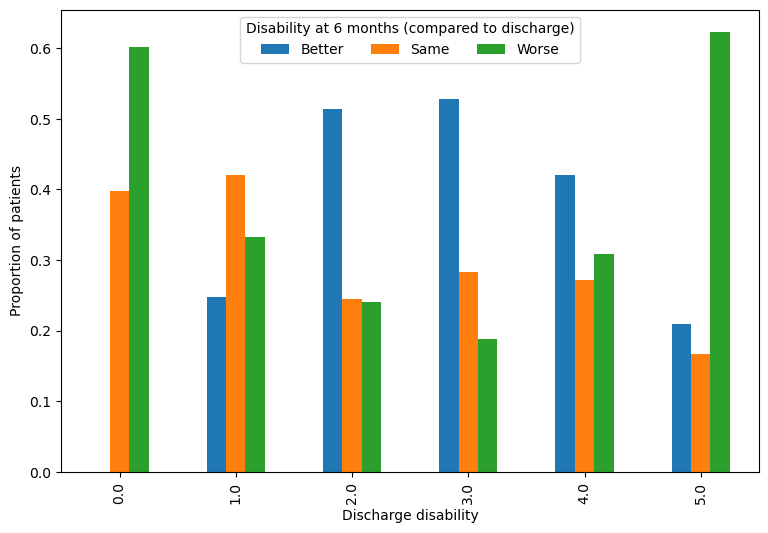

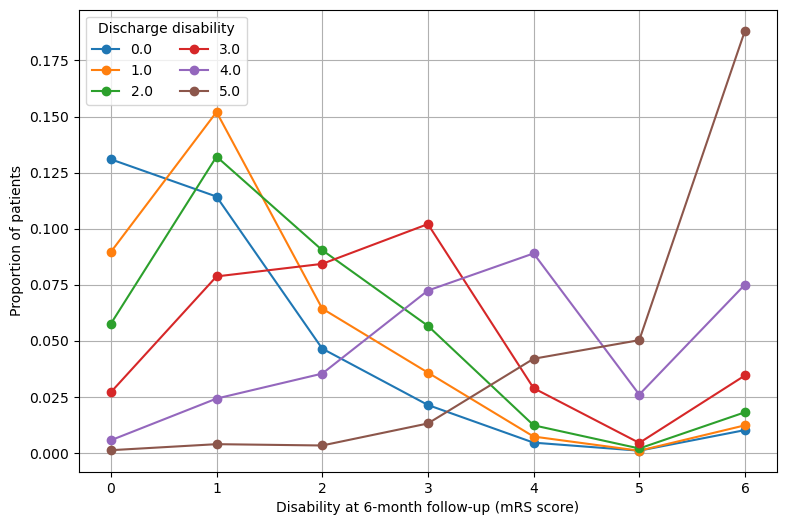

In [12]:
print('For patients with disability at discharge and 6 months')
print('who had arrived within 4 hours of known stroke onset...\n')
disability_change(data)
test = plot_disability_change(data)
plot_follow_up_by_discharge(data)

For all patients with scores at both times...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1


count    109321.00000
mean          0.11533
std           1.52376
min          -5.00000
25%          -1.00000
50%           0.00000
75%           1.00000
max           6.00000
dtype: float64

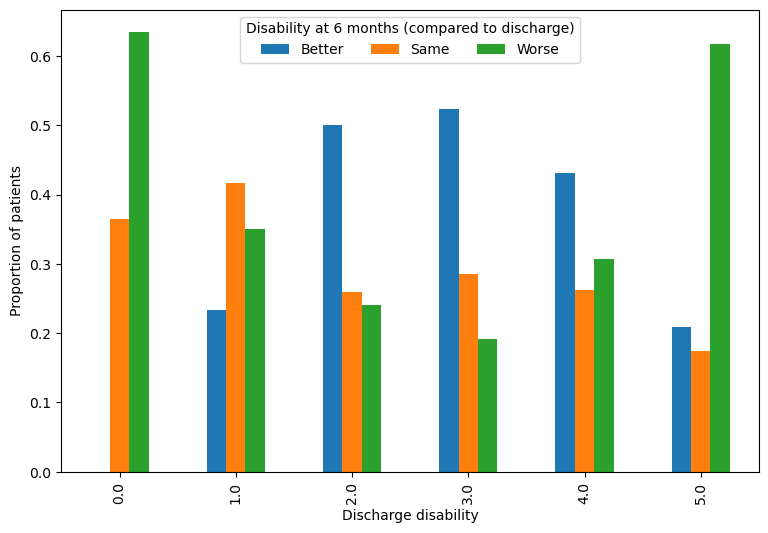

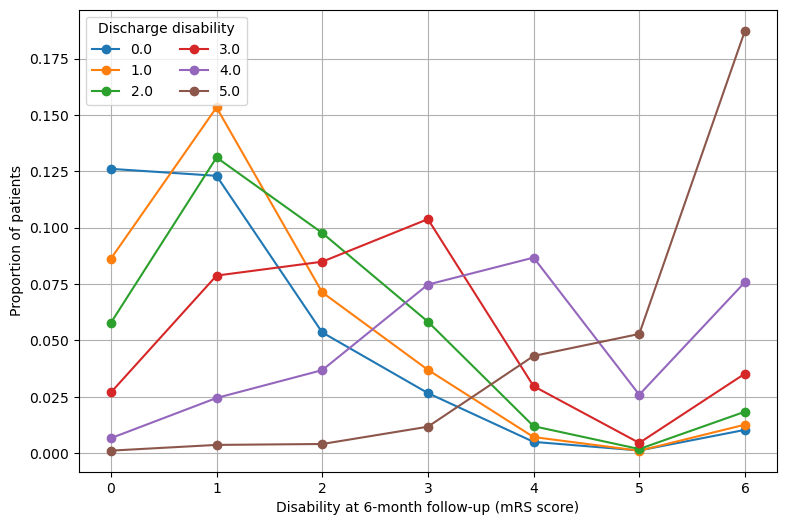

In [13]:
print('For all patients with scores at both times...\n')
disability_change(data_full)
plot_disability_change(data_full)
plot_follow_up_by_discharge(data_full)

## Regression

At present, the regression just uses the dataset of people who arrived within 4 hours of known stroke onset (data).

Details of regression:
* Uses k-fold (5-fold) training/test data splits (wherein each data point is present in one and only one of the five test sets)

In [14]:
# Extract relevant columns and drop rows with NA
reg_df = data[['prior_disability', 'stroke_severity', 'age',
               'thrombolysis', 'discharge_disability',
               'disability_6_month']].dropna()

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['disability_6_month'] - reg_df['discharge_disability']

# Choose metrics of interest
scoring = ['neg_mean_absolute_error', 'r2']

# Evaluate using 5-fold cross-validation
cv_results = cross_validate(LinearRegression(), X, y, cv=5,
                            scoring=scoring, return_estimator=True)

In [15]:
# View results
print(f'''
Negated MAE: {cv_results['test_neg_mean_absolute_error'].mean():.2f}
R-squared: {cv_results['test_r2'].mean():.2f}''')


Negated MAE: -1.05
R-squared: 0.17


In [16]:
# View coefficients and intercept
for model in cv_results['estimator']:
    display(pd.DataFrame({'variable': X.columns,
                          'coefficient': model.coef_}))
    print(f'Intercept = {model.intercept_}')

,variable,coefficient
0,prior_disability,0.331486
1,stroke_severity,0.048278
2,age,0.015164
3,thrombolysis,-0.280787
4,discharge_disability,-0.519885


Intercept = -0.4674800408975361


,variable,coefficient
0,prior_disability,0.317161
1,stroke_severity,0.051964
2,age,0.015065
3,thrombolysis,-0.290151
4,discharge_disability,-0.520826


Intercept = -0.4370487321705482


,variable,coefficient
0,prior_disability,0.320299
1,stroke_severity,0.049981
2,age,0.014480
3,thrombolysis,-0.274785
4,discharge_disability,-0.496232


Intercept = -0.43740189004533403


,variable,coefficient
0,prior_disability,0.345898
1,stroke_severity,0.049014
2,age,0.015484
3,thrombolysis,-0.271828
4,discharge_disability,-0.511030


Intercept = -0.5145264022890252


,variable,coefficient
0,prior_disability,0.328024
1,stroke_severity,0.051698
2,age,0.014364
3,thrombolysis,-0.303585
4,discharge_disability,-0.518365


Intercept = -0.4123065844031163
